In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Flow 圖片分類模型
6 個 CNN + 1 個 LSTM，將 6 張 PNG 圖輸入至 CNN，然後輸出序列送入 LSTM
分類為 26 類流量

In [9]:
import os
import zipfile
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. 解壓縮＆資料集定義

In [10]:
# 解壓縮 zip 檔
zip_path = "./drive/MyDrive/2.5_Flow_img_v2.zip"
extract_to = "./flows"

In [11]:
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)
print("解壓完成，資料夾：", os.listdir(extract_to))


解壓完成，資料夾： ['2.5_Flow_img']


In [16]:
# 建立 Dataset
class FlowDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.class_map = {}
        self.transform = transform
        label_dirs = sorted(os.listdir(root_dir))

        for idx, label_name in enumerate(label_dirs):
            label_path = os.path.join(root_dir, label_name)
            if not os.path.isdir(label_path):
                continue
            self.class_map[label_name] = idx
            for session_folder in os.listdir(label_path):
                session_path = os.path.join(label_path, session_folder)
                if not os.path.isdir(session_path):
                    continue
                imgs = [os.path.join(session_path, f"{i}.png") for i in range(6)]
                if all(os.path.exists(p) for p in imgs):
                    self.samples.append((imgs, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_paths, label = self.samples[idx]
        imgs = [Image.open(p).convert('L') for p in img_paths]
        if self.transform:
            imgs = [self.transform(im) for im in imgs]
        imgs = torch.stack(imgs)
        return imgs, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # 自動變成 shape: (1, 64, 64)
])

dataset = FlowDataset(os.path.join(extract_to, "2.5_Flow_img"), transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1024)

## 2. 模型定義：6 個 CNN + LSTM

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64*16*16, 128)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.cnns = nn.ModuleList([SimpleCNN() for _ in range(6)])
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        B = x.size(0)
        outs = []
        for i in range(6):
            outs.append(self.cnns[i](x[:,i]))
        seq = torch.stack(outs, dim=1)
        lstm_out, _ = self.lstm(seq)
        final = lstm_out[:, -1, :]
        return self.classifier(final)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 3. 訓練 & 測試函式

In [18]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    total_correct = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1)==labels).sum().item()
    return total_loss/len(loader.dataset), total_correct/len(loader.dataset)

def eval_model(loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(1)
            total_correct += (preds==labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss/len(loader.dataset), total_correct/len(loader.dataset), all_preds, all_labels

## 4. 開始訓練

In [19]:
EPOCHS = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []
best_acc = 0
for ep in range(1, EPOCHS+1):
    tl, ta = train_epoch(train_loader)
    vl, va, _, _ = eval_model(test_loader)
    train_losses.append(tl); train_accs.append(ta)
    test_losses.append(vl); test_accs.append(va)
    print(f"Epoch {ep}, train_loss={tl:.4f}, train_acc={ta:.4f}, test_acc={va:.4f}")
    if va > best_acc:
        best_acc = va
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1, train_loss=2.2050, train_acc=0.3592, test_acc=0.5599
Epoch 2, train_loss=0.7411, train_acc=0.6967, test_acc=0.7548
Epoch 3, train_loss=0.3981, train_acc=0.7828, test_acc=0.7909
Epoch 4, train_loss=0.3423, train_acc=0.8169, test_acc=0.8120
Epoch 5, train_loss=0.2900, train_acc=0.8471, test_acc=0.8398
Epoch 6, train_loss=0.2486, train_acc=0.8713, test_acc=0.8702
Epoch 7, train_loss=0.2152, train_acc=0.8940, test_acc=0.8881
Epoch 8, train_loss=0.1836, train_acc=0.9154, test_acc=0.9026
Epoch 9, train_loss=0.1481, train_acc=0.9355, test_acc=0.9140
Epoch 10, train_loss=0.1191, train_acc=0.9500, test_acc=0.9204


KeyboardInterrupt: 

## 5. 繪圖與混淆矩陣

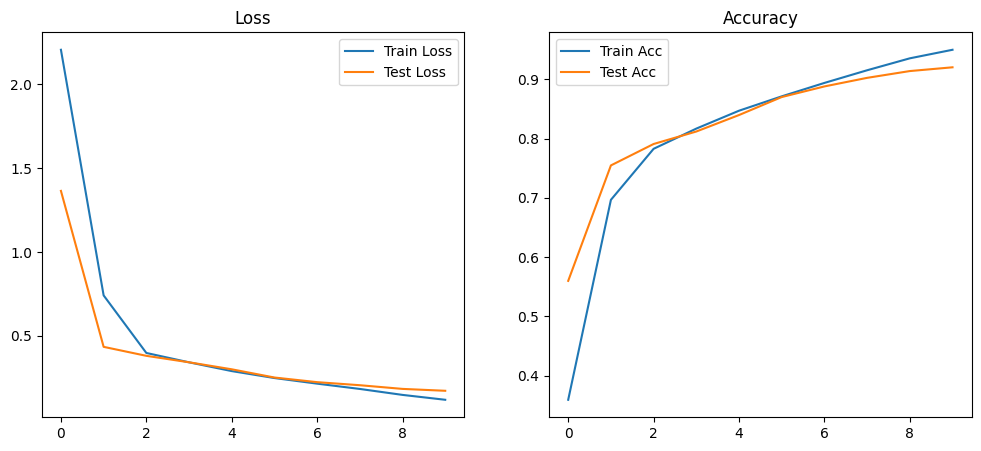

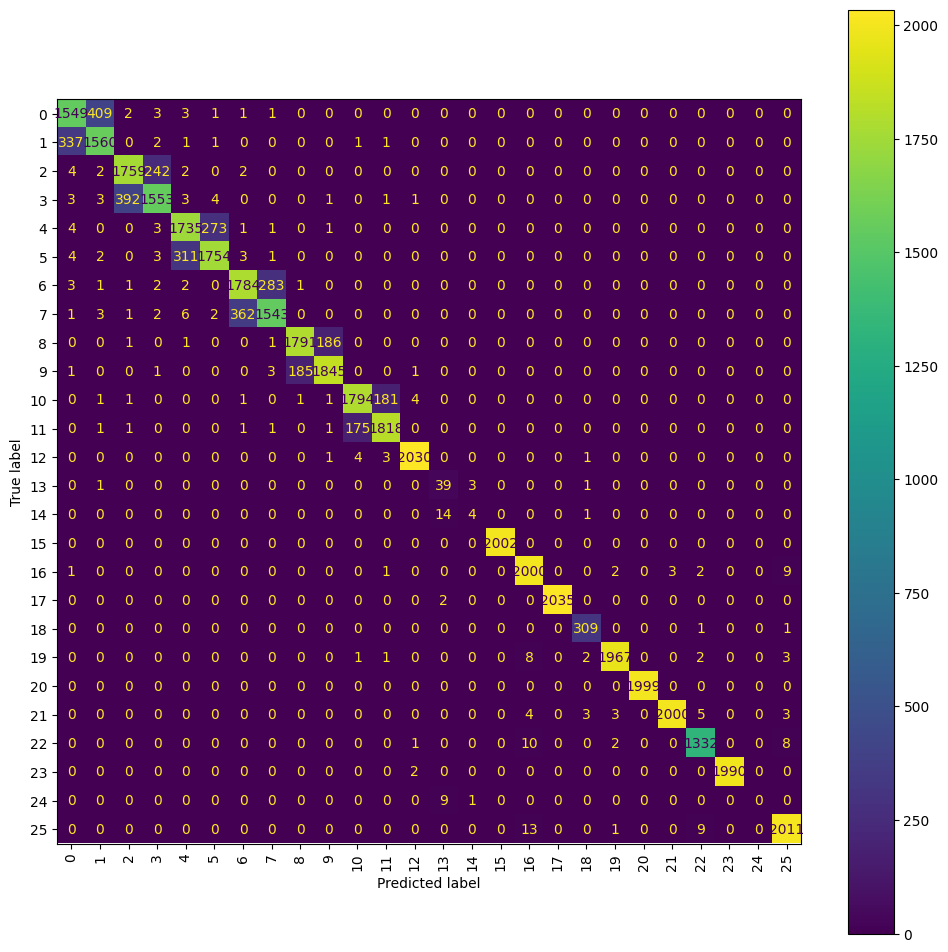

In [22]:
# Loss & Accuracy 圖
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# 混淆矩陣
_,_, preds, trues = eval_model(test_loader)
cm = confusion_matrix(trues, preds)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, xticks_rotation=90)
plt.show()

In [21]:
# 儲存模型
torch.save(model.state_dict(), "cnn_lstm_hast_model.pth")